# • Probabilistic Long-Horizon Forecast


Long-horizon forecasting is challenging because of the *volatility* of the predictions and the *computational complexity*. To solve this problem we created the [NHITS](https://arxiv.org/abs/2201.12886) model and made the code available [NeuralForecast library](https://nixtla.github.io/neuralforecast/models.nhits.html). `NHITS` specializes its partial outputs in the different frequencies of the time series through hierarchical interpolation and multi-rate input processing. We model the target time-series with Student's t-distribution. The `NHITS` will output the distribution parameters for each timestamp. 

In this notebook we show how to use N-HiTS on the [ETTm2](https://github.com/zhouhaoyi/ETDataset) benchmark dataset for probabilistic forecasting. This data set includes data points for 2 Electricity Transformers at 2 stations, including load, oil temperature.

We will show you how to load data, train, and perform automatic hyperparameter tuning, **to achieve SoTA performance**, outperforming even the latest Transformer architectures for a fraction of their computational cost (50x faster).

You can run these experiments using GPU with Google Colab.

<a href="https://colab.research.google.com/github/Nixtla/neuralforecast/blob/main/nbs/examples/LongHorizon_Probabilistic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Libraries

In [ ]:
%%capture
!pip install git+https://github.com/Nixtla/neuralforecast

In [ ]:
%%capture
!pip install datasetsforecast

In [ ]:
import torch
import pandas as pd
from datasetsforecast.long_horizon import LongHorizon

In [ ]:
torch.cuda.is_available()

True

## 2. Load ETTm2 Data

The `LongHorizon` class will automatically download the complete ETTm2 dataset and process it.

It return three Dataframes: `Y_df` contains the values for the target variables, `X_df` contains exogenous calendar features and `S_df` contains static features for each time-series (none for ETTm2). For this example we will only use `Y_df`.

If you want to use your own data just replace `Y_df`. Be sure to use a long format and have a simmilar structure than our data set.

In [ ]:
# Change this to your own data to try the model
Y_df, _, _ = LongHorizon.load(directory='./', group='ETTm2')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

# For this excercise we are going to take 960 timestamps as validation and test
n_time = len(Y_df.ds.unique())
val_size = 96*10
test_size = 96*10

Y_df.groupby('unique_id').head(2)

,unique_id,ds,y
0,HUFL,2016-07-01 00:00:00,-0.041413
1,HUFL,2016-07-01 00:15:00,-0.185467
57600,HULL,2016-07-01 00:00:00,0.040104
57601,HULL,2016-07-01 00:15:00,-0.214450
115200,LUFL,2016-07-01 00:00:00,0.695804
115201,LUFL,2016-07-01 00:15:00,0.434685
172800,LULL,2016-07-01 00:00:00,0.434430
172801,LULL,2016-07-01 00:15:00,0.428168
230400,MUFL,2016-07-01 00:00:00,-0.599211
230401,MUFL,2016-07-01 00:15:00,-0.658068


:::{.callout-important}
DataFrames must include all `['unique_id', 'ds', 'y']` columns.
Make sure `y` column does not have missing or non-numeric values. 
:::

Next, plot the `HUFL` variable marking the validation and train splits.

In [ ]:
import matplotlib.pyplot as plt

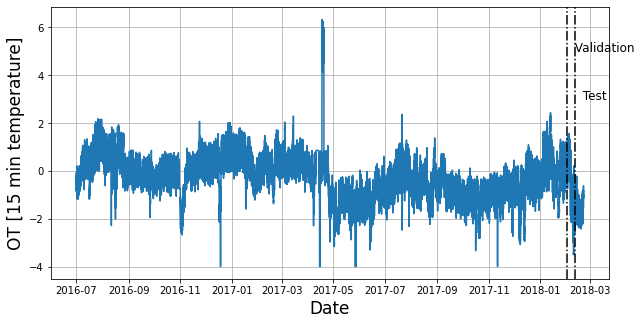

In [ ]:
# We are going to plot the temperature of the transformer 
# and marking the validation and train splits
u_id = 'HUFL'
x_plot = pd.to_datetime(Y_df[Y_df.unique_id==u_id].ds)
y_plot = Y_df[Y_df.unique_id==u_id].y.values

x_val = x_plot[n_time - val_size - test_size]
x_test = x_plot[n_time - test_size]

fig = plt.figure(figsize=(10, 5))
fig.tight_layout()

plt.plot(x_plot, y_plot)
plt.xlabel('Date', fontsize=17)
plt.ylabel('OT [15 min temperature]', fontsize=17)

plt.axvline(x_val, color='black', linestyle='-.')
plt.axvline(x_test, color='black', linestyle='-.')
plt.text(x_val, 5, '  Validation', fontsize=12)
plt.text(x_test, 3, '  Test', fontsize=12)

plt.grid()
plt.show()
plt.close()

## 3. Hyperparameter selection and forecasting

The `AutoNHITS` class contains a pre-defined suggested hyperparameter space, built for the [Hyperopt library](https://iopscience.iop.org/article/10.1088/1749-4699/8/1/014008/meta).  This function only needs dataframe specific information such as the number of series and frequency. Feel free to play around with this space.

The parameter `h` is used to specify the desired forecasting horizon. To replicate results for other horizons from the paper, just change this value!

The  `AutoNHITS.default_config` attribute contains a suggested hyperparameter space. Here we send the paper's config. Notice that *1000 Stochastic Gradient Steps* are enough to achieve SoTA performance. You can override the NHiTS `config` for each hyperparameter.

In [ ]:
from ray import tune

from neuralforecast.auto import AutoNHITS
from neuralforecast.core import NeuralForecast

from neuralforecast.losses.pytorch import DistributionLoss

import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

In [ ]:
horizon = 96 # 24hrs = 4 * 15 min.

# Use your own config or AutoNHITS.default_config
nhits_config = {
       "learning_rate": tune.choice([1e-3]),                                     # Initial Learning rate
       "max_steps": tune.choice([1000]),                                         # Number of SGD steps
       "input_size": tune.choice([5 * horizon]),                                 # input_size = multiplier * horizon
       "batch_size": tune.choice([7]),                                           # Number of series in windows
       "windows_batch_size": tune.choice([256]),                                 # Number of windows in batch
       "n_pool_kernel_size": tune.choice([[2, 2, 2], [16, 8, 1]]),               # MaxPool's Kernelsize
       "n_freq_downsample": tune.choice([[168, 24, 1], [24, 12, 1], [1, 1, 1]]), # Interpolation expressivity ratios
       "activation": tune.choice(['ReLU']),                                      # Type of non-linear activation
       "n_blocks":  tune.choice([[1, 1, 1]]),                                    # Blocks per each 3 stacks
       "mlp_units":  tune.choice([[[512, 512], [512, 512], [512, 512]]]),        # 2 512-Layers per block for each stack
       "interpolation_mode": tune.choice(['linear']),                            # Type of multi-step interpolation
       "random_seed": tune.randint(1, 10),
       "loss": DistributionLoss(distribution='StudentT', level=[80, 90]),
       "scaler_type": tune.choice(['robust']),
       "check_val_every_n_epoch": tune.choice([100])
    }

:::{.callout-tip}
Refer to https://docs.ray.io/en/latest/tune/index.html for more information on the different space options, such as lists and continous intervals.m
:::

We fit the model by instantiating a `NeuralForecast` object with the following required parameters:

* `models`: a list of models.

* `freq`: a string indicating the frequency of the data. (See [panda's available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).)

In [ ]:
# Fit and predict
fcst = NeuralForecast(
    models=[AutoNHITS(h=horizon, config=nhits_config, 
                      num_samples=5)], # control of hyperopt samples
    freq='15min')

The `cross_validation` method allows the user to simulate multiple historic forecasts, greatly simplifying pipelines by replacing for loops with `fit` and `predict` methods.

With time series data, Cross Validation is done by defining a sliding window across the historical data and predicting the period following it. This form of cross-validation allows us to arrive at a better estimation of our model’s predictive abilities across a wider range of temporal instances while also keeping the data in the training set contiguous as is required by our models.

The `cross_validation` method will use the validation set for hyperparameter selection, and will then produce the forecasts for the test set.

In [ ]:
%%capture
fcst_df = fcst.cross_validation(df=Y_df, val_size=val_size,
                                test_size=test_size, n_windows=None)

## 4. Visualization

Finally, we merge the forecasts with the `Y_df` dataset and plot the forecasts.

In [ ]:
Y_hat_df = fcst_df.reset_index(drop=True)
Y_hat_df = Y_hat_df[(Y_hat_df['unique_id']=='OT') & (Y_hat_df['cutoff']=='2018-02-11 12:00:00')]
Y_hat_df = Y_hat_df.drop(columns=['y','cutoff'])

[]

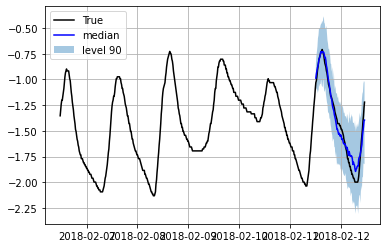

In [ ]:
plot_df = Y_df.merge(Y_hat_df, on=['unique_id','ds'], how='outer').tail(96*10+50+96*4).head(96*2+96*4)

plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['AutoNHITS-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'], 
                    y1=plot_df['AutoNHITS-lo-90.0'], y2=plot_df['AutoNHITS-hi-90.0'],
                    alpha=0.4, label='level 90')
plt.legend()
plt.grid()
plt.plot()